# Quick study: Post-shock sound speeds

In [1]:
import sdtoolbox
import cantera as ct
import numpy as np
from scipy.optimize import minimize

import seaborn as sns
from matplotlib import pyplot as plt

from funcs.simulation import thermo

In [2]:
initial_pressure = 101_325
initial_temperature = 300
mech = "gri30.xml"
fuel = "CH4"
oxidizer = "N2O"
gas = ct.Solution(mech)
gas.set_equivalence_ratio(1.0, fuel, oxidizer)
q = gas.mole_fraction_dict()

## CJ Speed

In [3]:
cj_speed = sdtoolbox.postshock.CJspeed(
    P1=initial_pressure,
    T1=initial_temperature,
    q=q,
    mech=mech,
)
cj_speed

2197.0811946287945

## Post-shock states

In [4]:
gas_eq = sdtoolbox.postshock.PostShock_eq(
    U1=cj_speed,
    P1=initial_pressure,
    T1=initial_temperature,
    q=q,
    mech=mech,
    perturbed_rxn_no=None,
    perturbation_fraction=None,
)
gas_eq.TP

(3630.4533028416436, 3548931.284754403)

In [5]:
gas_fr = sdtoolbox.postshock.PostShock_fr(
    U1=cj_speed,
    P1=initial_pressure,
    T1=initial_temperature,
    q=q,
    mech=mech,
    perturbed_rxn_no=None,
    perturbation_fraction=None,
)
gas_fr.TP

(1884.492063349297, 6944389.931037229)

## Sound Speeds

In [6]:
a_eq = sdtoolbox.thermo.soundspeed_eq(gas_eq)
a_eq

1190.0835965372191

In [7]:
a_fr = sdtoolbox.thermo.soundspeed_fr(gas_fr)
a_fr

681.409900643372

In [8]:
gas_eq.mole_fraction_dict()[fuel]

7.842445619329823e-12

In [9]:
gas_fr.mole_fraction_dict()[fuel]

0.2

We want to use equilibrium because CJ is the post-shock equilibrium state

In [3]:
mol_fracs = np.linspace(0, 0.8, 21)
co2_speeds = np.zeros_like(mol_fracs)
n2_speeds = np.zeros_like(mol_fracs)
for i, mol_frac in enumerate(mol_fracs):
    co2_speeds[i] = thermo.get_sound_speed(
        mech="gri30.xml",
        fuel="CH4",
        oxidizer="N2O",
        phi=1.0,
        diluent="CO2",
        diluent_mol_frac=mol_frac,
        init_temp=300,
        init_press=101325,
    )
    n2_speeds[i] = thermo.get_sound_speed(
        mech="gri30.xml",
        fuel="CH4",
        oxidizer="N2O",
        phi=1.0,
        diluent="N2",
        diluent_mol_frac=mol_frac,
        init_temp=300,
        init_press=101325,
    )

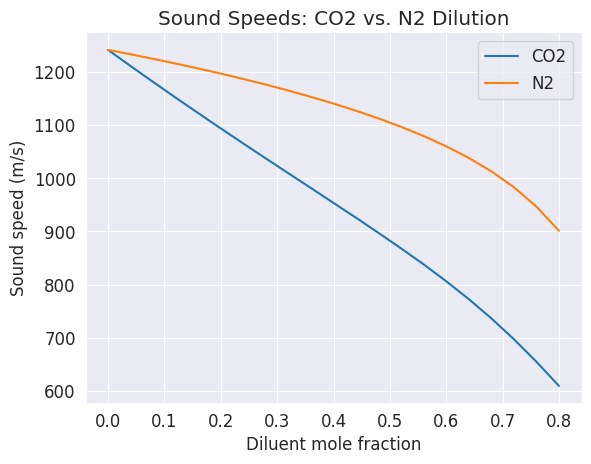

In [4]:
sns.set_style("darkgrid")
plt.plot(mol_fracs, co2_speeds, label="CO2")
plt.plot(mol_fracs, n2_speeds, label="N2")
plt.legend()
plt.title("Sound Speeds: CO2 vs. N2 Dilution")
plt.xlabel("Diluent mole fraction")
plt.ylabel("Sound speed (m/s)")
sns.despine()

In [6]:
co2 = thermo.get_sound_speed(
    mech="gri30.xml",
    fuel="CH4",
    oxidizer="N2O",
    phi=1.0,
    diluent="CO2",
    diluent_mol_frac=0.2,
    init_temp=300,
    init_press=101325,
)
n2 = thermo.get_sound_speed(
    mech="gri30.xml",
    fuel="CH4",
    oxidizer="N2O",
    phi=1.0,
    diluent="N2",
    diluent_mol_frac=0.525,
    init_temp=300,
    init_press=101325,
)
co2, n2

(1094.0055444473815, 1094.9020707549241)

In [8]:
n2_match = thermo.match_sound_speed(
    mech="gri30.xml",
    fuel="CH4",
    oxidizer="N2O",
    phi=1.0,
    dil_original="CO2",
    dil_original_mol_frac=0.2,
    dil_new="N2",
    init_temp=300,
    init_press=101325,
)
n2_match

0.5271442604064953

In [9]:
thermo.get_sound_speed(
    mech="gri30.xml",
    fuel="CH4",
    oxidizer="N2O",
    phi=1.0,
    diluent="N2",
    diluent_mol_frac=n2_match,
    init_temp=300,
    init_press=101325,
)

1094.0055510282582

In [10]:
mol_fracs

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 ])

In [20]:
from scipy import interpolate

In [29]:
cs = interpolate.CubicSpline(n2_speeds[::-1], mol_fracs[::-1])

In [37]:
test2 = cs(co2)[()]
test2

0.5271340074331009

In [38]:
thermo.get_sound_speed(
    mech="gri30.xml",
    fuel="CH4",
    oxidizer="N2O",
    phi=1.0,
    diluent="N2",
    diluent_mol_frac=test2,
    init_temp=300,
    init_press=101325,
)

1094.0098248346653

In [25]:
test = np.interp(co2, n2_speeds[::-1], mol_fracs[::-1])
test

0.5268584584117812

In [26]:
thermo.get_sound_speed(
    mech="gri30.xml",
    fuel="CH4",
    oxidizer="N2O",
    phi=1.0,
    diluent="N2",
    diluent_mol_frac=test,
    init_temp=300,
    init_press=101325,
)

1094.1243521560143

In [27]:
co2

1094.0055444473815